# Load Data 

In [46]:
import os, glob

from polyssifier import poly, polyr
import numpy as np
import torch

import datetime

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import random
import h5py
import time
import pickle as p
from datetime import datetime
from keras.utils import np_utils
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
from __future__ import print_function
import random
import time

from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import (f1_score, confusion_matrix, roc_auc_score,
                             mean_squared_error, r2_score)
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression  #For logistic regression
from sklearn.neighbors import KNeighborsClassifier
import pickle as p

from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV


path = './PreprocessedDatasets/' + '*.csv'
files = glob.glob(path)
data = []
for file in files:
    print(file)
    data.append(pd.read_csv(file, sep='\t', index_col=False))


finalData = pd.concat(data, axis=0, ignore_index=True)

finalData2 = finalData.to_numpy(dtype=float)

./PreprocessedDatasets/stable-middistance.csv
./PreprocessedDatasets/stable-shortdistance.csv
./PreprocessedDatasets/stable-longdistance.csv
./PreprocessedDatasets/moving-away.csv
./PreprocessedDatasets/moving-closerfarcloser.csv
./PreprocessedDatasets/stable-shortistance2.csv


# Find the correlation matrix and select features

In [47]:
finalData2 = finalData2.T
print(finalData2.shape)

corrData = np.corrcoef(finalData2)
corrData = np.nan_to_num(corrData)
print('Correlation Matrix...')
print(corrData.shape)

df = pd.DataFrame(data=corrData, index=[np.arange(1, 43, 1)], columns=[np.arange(1, 43, 1)])

(42, 27726)
Correlation Matrix...
(42, 42)


/Users/mdmahfuzurrahman/anaconda3/envs/tensor/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/mdmahfuzurrahman/anaconda3/envs/tensor/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


# Display the heatmap

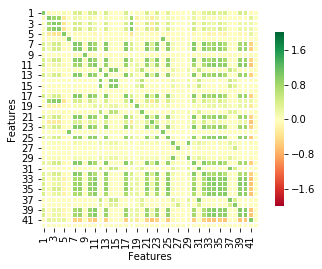

In [48]:
df.index.names = ['Features']
df.columns.names = ['Features']
# print(df)

fig = plt.figure()

# plot heatmap
ax=sb.heatmap(df, cmap="RdYlGn", vmin= -2, vmax=2, square=True,
           linewidth=0.3, cbar_kws={"shrink": .8})

plt.show()

# Select features highly associated with wbCQI

In [49]:
arr = df.to_numpy()[3, :]
idx = np.argsort(-arr)[:17]
print(idx)

S = np.array(finalData.columns.tolist())
print(S[idx])
attributesFinal = S[idx][2:].tolist()
labelAttrb = S[idx][0].tolist()
print(attributesFinal)
print(labelAttrb)

[ 3 17  2  1 29  9 20 22  6 24 34 16 12  7 31 32 35]
['wbcqi' 'macStats_mcs1Dl' 'rsrq' 'rsrp' 'pdcpStats_pktRxSn'
 'macStats_totalPduDl' 'macStats_totalPrbDl' 'macStats_totalTbsDl'
 'macStats_totalBytesSdusDl' 'pdcpStats_pktRx' 'pdcpStats_pktRxBytes'
 'macStats_totalPduUl' 'macStats_totalPrbUl' 'macStats_totalTbsUl'
 'pdcpStats_pktTxSn' 'pdcpStats_pktTxBytes' 'pdcpStats_pktTx']
['rsrq', 'rsrp', 'pdcpStats_pktRxSn', 'macStats_totalPduDl', 'macStats_totalPrbDl', 'macStats_totalTbsDl', 'macStats_totalBytesSdusDl', 'pdcpStats_pktRx', 'pdcpStats_pktRxBytes', 'macStats_totalPduUl', 'macStats_totalPrbUl', 'macStats_totalTbsUl', 'pdcpStats_pktTxSn', 'pdcpStats_pktTxBytes', 'pdcpStats_pktTx']
wbcqi


# Prepare Data for the Regression Analysis

Finding which features are statistically related to wbCQI (wideband channel quality indicator)

In [50]:
workingData = finalData[attributesFinal].astype(float)
workingData.reset_index(drop=True, inplace=True)
labels = finalData[[labelAttrb]].astype(float)
labels.reset_index(drop=True, inplace=True)
print(workingData)
print(labels)

workingData = workingData.values
labels = labels.values
labels = np.squeeze(labels)

       rsrq   rsrp  pdcpStats_pktRxSn  macStats_totalPduDl  \
0      -8.0 -107.0              394.0                664.0   
1      -8.0 -107.0              394.0                664.0   
2      -8.0 -107.0              394.0                663.0   
3      -8.0 -107.0              394.0                663.0   
4      -8.0 -107.0              394.0                662.0   
...     ...    ...                ...                  ...   
27721  -2.0  -94.0              111.0                 33.0   
27722  -2.0  -94.0              111.0                 33.0   
27723  -2.0  -94.0              111.0                 32.0   
27724  -2.0  -94.0              111.0                 32.0   
27725  -2.0  -94.0              109.0                 32.0   

       macStats_totalPrbDl  macStats_totalTbsDl  macStats_totalBytesSdusDl  \
0                   2083.0              12134.0                     8647.0   
1                   2083.0              12134.0                     8647.0   
2                   2

# Use Polyssifier for regression analysis - covering a bunch of regression methods 
- Linear Regression
- Bayesian Ridge
- Ridge
- Lasso
- OrthogonalMatchingPursuit
- ElasticNet

2020-11-27 15:11:05,165 - polyssifier - INFO - Building classifiers ...
2020-11-27 15:11:05,206 - polyssifier - INFO - Initialization, done.
2020-11-27 15:11:05,335 - polyssifier - INFO - Loading polyr_r2_eHealthData/models/Linear Regression_1.p 0
2020-11-27 15:11:05,400 - polyssifier - INFO - Linear Regression          0: Train 0.91/Test 0.96, 0.07 sec
2020-11-27 15:11:05,458 - polyssifier - INFO - Loading polyr_r2_eHealthData/models/Linear Regression_2.p 1
2020-11-27 15:11:05,506 - polyssifier - INFO - Linear Regression          1: Train 0.89/Test 0.99, 0.05 sec
2020-11-27 15:11:05,571 - polyssifier - INFO - Loading polyr_r2_eHealthData/models/Linear Regression_3.p 2
2020-11-27 15:11:05,621 - polyssifier - INFO - Linear Regression          2: Train 0.90/Test 0.82, 0.05 sec
2020-11-27 15:11:05,700 - polyssifier - INFO - Loading polyr_r2_eHealthData/models/Linear Regression_4.p 3
2020-11-27 15:11:05,754 - polyssifier - INFO - Linear Regression          3: Train 0.69/Test 0.73, 0.05 sec

                                     mean       std       min       max
Linear Regression         train  0.860407  0.098571  0.685611  0.921668
                          test   0.448886  0.959482 -1.257563  0.985516
Bayesian Ridge            train  0.864139  0.090452  0.704305  0.921648
                          test   0.471977  0.908236 -1.142234  0.985581
Ridge                     train  0.921774  0.019088  0.900210  0.942478
                          test   0.843974  0.123734  0.718338  0.984934
Lasso                     train  0.906652  0.013546  0.885010  0.920167
                          test   0.813481  0.138721  0.653585  0.975599
OrthogonalMatchingPursuit train  0.914963  0.018884  0.889375  0.934239
                          test   0.821047  0.136048  0.673783  0.983584
ElasticNet                train  0.896730  0.018756  0.869135  0.913266
                          test   0.793863  0.153448  0.653585  0.975599
Median                    train  0.919772  0.015864  0.901602  0

2020-11-27 15:11:09,547 - Report - INFO - Plotting Linear Regression coefs to polyr_r2_eHealthData/temp_Linear Regression_feature_ranking.png
2020-11-27 15:11:09,764 - Report - INFO - Plotting Bayesian Ridge coefs to polyr_r2_eHealthData/temp_Bayesian Ridge_feature_ranking.png
2020-11-27 15:11:10,106 - Report - INFO - Plotting Ridge coefs to polyr_r2_eHealthData/temp_Ridge_feature_ranking.png
2020-11-27 15:11:10,357 - Report - INFO - Plotting Lasso coefs to polyr_r2_eHealthData/temp_Lasso_feature_ranking.png
2020-11-27 15:11:10,599 - Report - INFO - Plotting OrthogonalMatchingPursuit coefs to polyr_r2_eHealthData/temp_OrthogonalMatchingPursuit_feature_ranking.png
2020-11-27 15:11:10,833 - Report - INFO - Plotting ElasticNet coefs to polyr_r2_eHealthData/temp_ElasticNet_feature_ranking.png


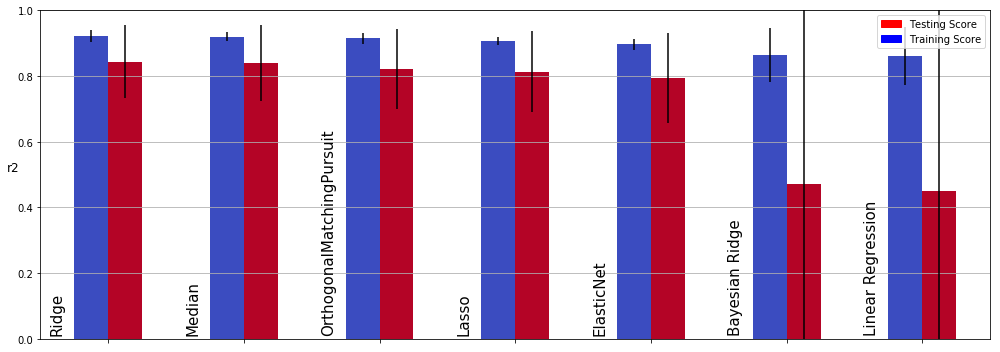

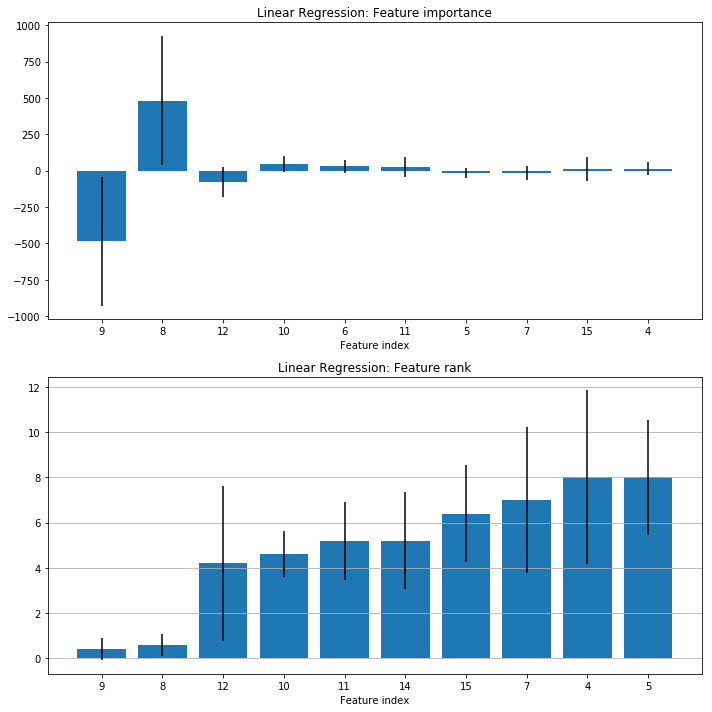

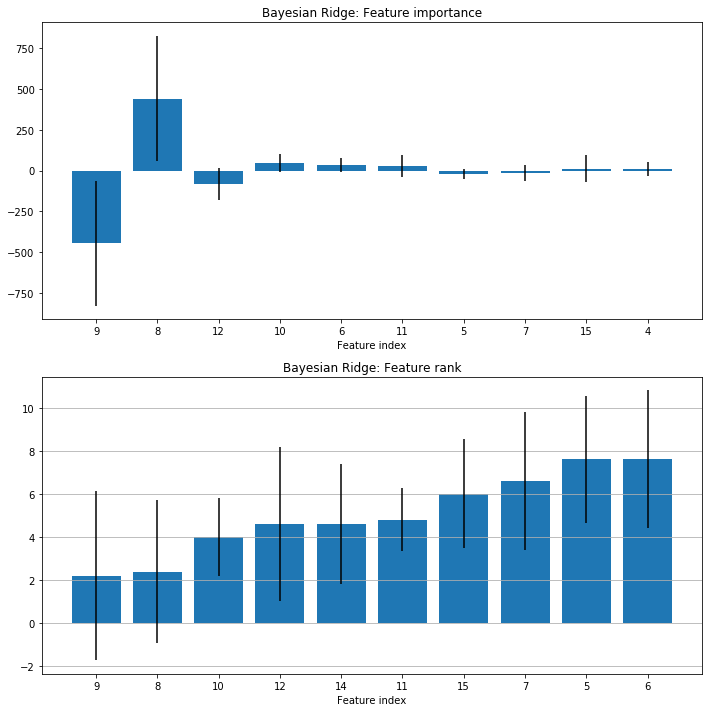

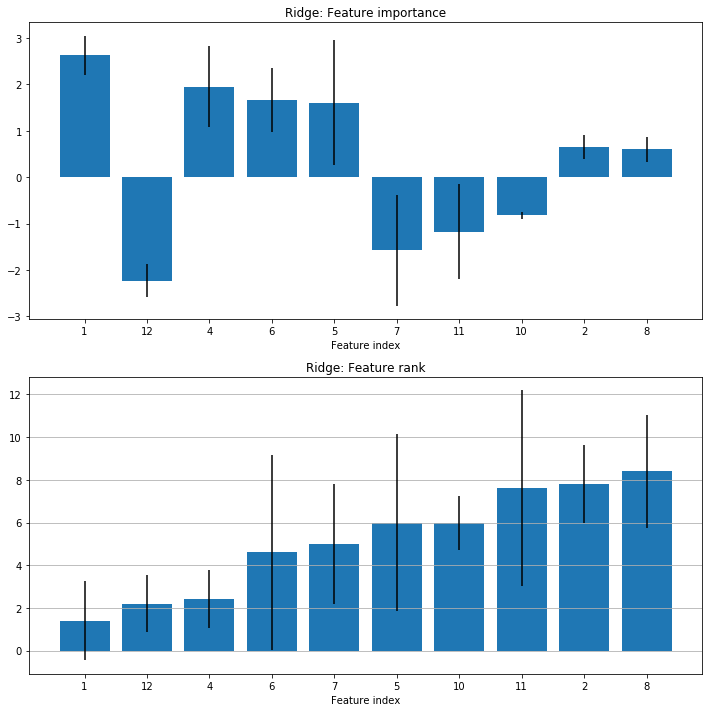

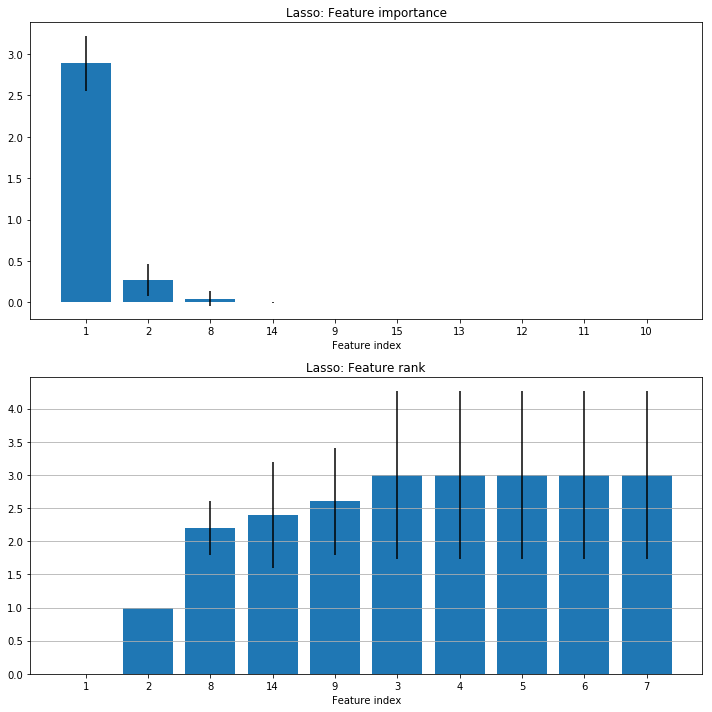

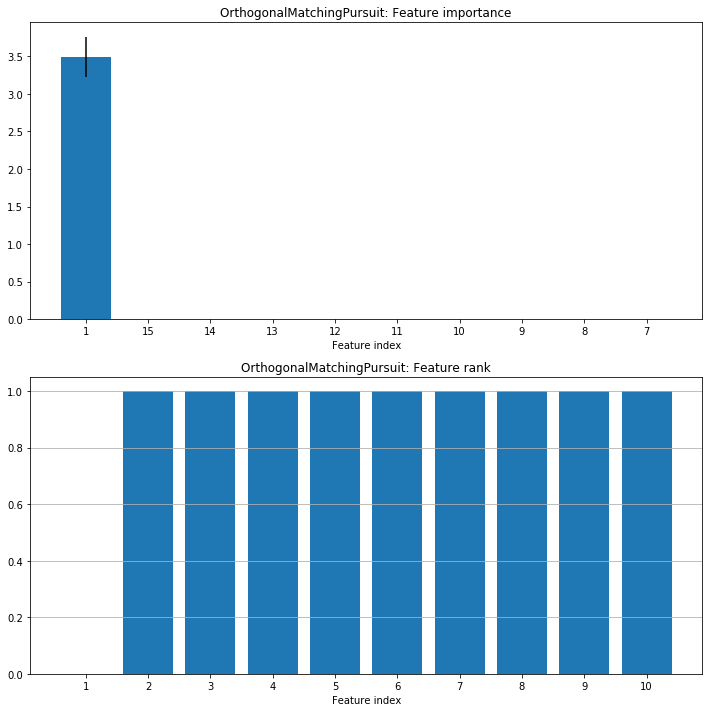

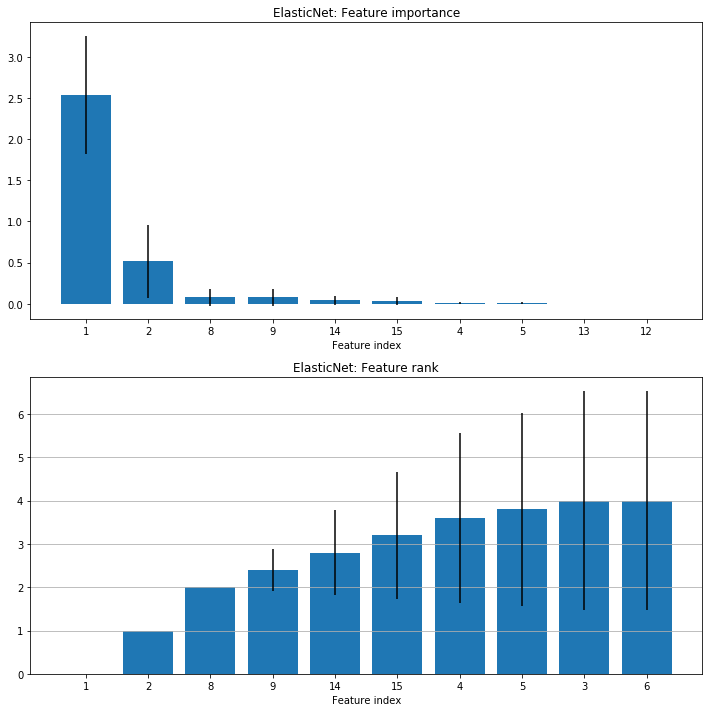

In [51]:
dataset ='r2_eHealthData'

# global  report
report = polyr(workingData, labels, n_folds=5, verbose=2, concurrency=1, feature_selection=False, scoring='r2', save=True,  project_name=dataset, exclude = ['PassiveAggressiveRegressor', 'GaussianProcessRegressor','Lars', 'LassoLars', 'Median'])

dir = 'polyr_' + dataset
with open(dir + '/report.pkl', 'wb') as f:
    p.dump(report, f, protocol=2)

report.scores.to_csv(dir+'/Scores_Detail.csv')
B = report.scores.astype('float').describe().transpose()[['mean', 'std', 'min', 'max']]
B.to_csv(dir+'/Scores_Report.csv')

with open(dir + '/report.pkl', 'rb') as p_f:
    report = p.load(p_f)

print(report.scores)
# Plot results
report.plot_scores(path=dir+'/temp')
report.plot_features(ntop=10, path=dir+'/temp')

# Use MSE instead of R2 score

2020-11-27 15:11:45,617 - polyssifier - INFO - Building classifiers ...
2020-11-27 15:11:45,651 - polyssifier - INFO - Initialization, done.
2020-11-27 15:11:45,752 - polyssifier - INFO - Loading polyr_mse_eHealthData/models/Linear Regression_1.p 0
2020-11-27 15:11:45,804 - polyssifier - INFO - Linear Regression          0: Train 1.36/Test 0.42, 0.05 sec
2020-11-27 15:11:45,867 - polyssifier - INFO - Loading polyr_mse_eHealthData/models/Linear Regression_2.p 1
2020-11-27 15:11:45,914 - polyssifier - INFO - Linear Regression          1: Train 1.61/Test 0.18, 0.05 sec
2020-11-27 15:11:45,976 - polyssifier - INFO - Loading polyr_mse_eHealthData/models/Linear Regression_3.p 2
2020-11-27 15:11:46,021 - polyssifier - INFO - Linear Regression          2: Train 0.89/Test 1.25, 0.05 sec
2020-11-27 15:11:46,082 - polyssifier - INFO - Loading polyr_mse_eHealthData/models/Linear Regression_4.p 3
2020-11-27 15:11:46,124 - polyssifier - INFO - Linear Regression          3: Train 4.56/Test 1.58, 0.04

                                     mean       std       min        max
Linear Regression         train  1.918976  1.501602  0.886932   4.563595
                          test   2.931275  4.678698  0.177484  11.237196
Bayesian Ridge            train  1.864436  1.384139  0.887652   4.292235
                          test   2.816254  4.424144  0.176696  10.663136
Ridge                     train  1.026425  0.211929  0.834975   1.308691
                          test   0.970264  0.632107  0.184617   1.664598
Lasso                     train  1.231103  0.124784  1.047430   1.358792
                          test   1.178344  0.640119  0.299014   1.724308
OrthogonalMatchingPursuit train  1.113203  0.165940  0.988439   1.340815
                          test   1.120650  0.671650  0.201162   1.623953
ElasticNet                train  1.231103  0.124784  1.047430   1.358792
                          test   1.178344  0.640119  0.299014   1.724308
Median                    train  1.034856  0.150152

2020-11-27 15:11:49,579 - Report - INFO - Plotting Linear Regression coefs to polyr_mse_eHealthData/temp_Linear Regression_feature_ranking.png
2020-11-27 15:11:49,800 - Report - INFO - Plotting Bayesian Ridge coefs to polyr_mse_eHealthData/temp_Bayesian Ridge_feature_ranking.png
2020-11-27 15:11:50,046 - Report - INFO - Plotting Ridge coefs to polyr_mse_eHealthData/temp_Ridge_feature_ranking.png
2020-11-27 15:11:50,247 - Report - INFO - Plotting Lasso coefs to polyr_mse_eHealthData/temp_Lasso_feature_ranking.png
2020-11-27 15:11:50,459 - Report - INFO - Plotting OrthogonalMatchingPursuit coefs to polyr_mse_eHealthData/temp_OrthogonalMatchingPursuit_feature_ranking.png
2020-11-27 15:11:50,664 - Report - INFO - Plotting ElasticNet coefs to polyr_mse_eHealthData/temp_ElasticNet_feature_ranking.png


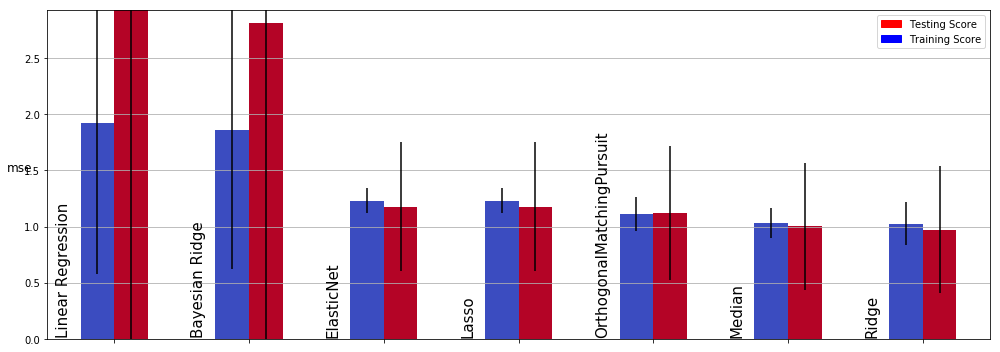

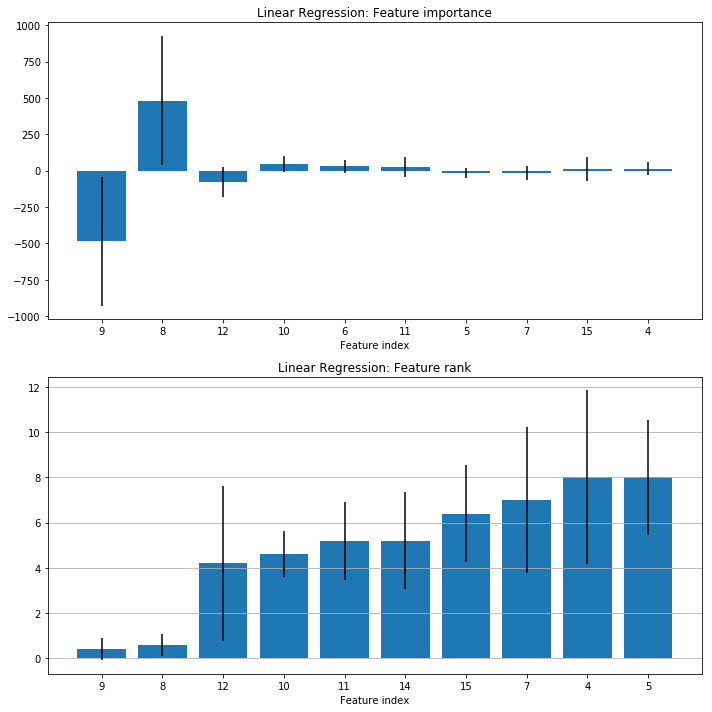

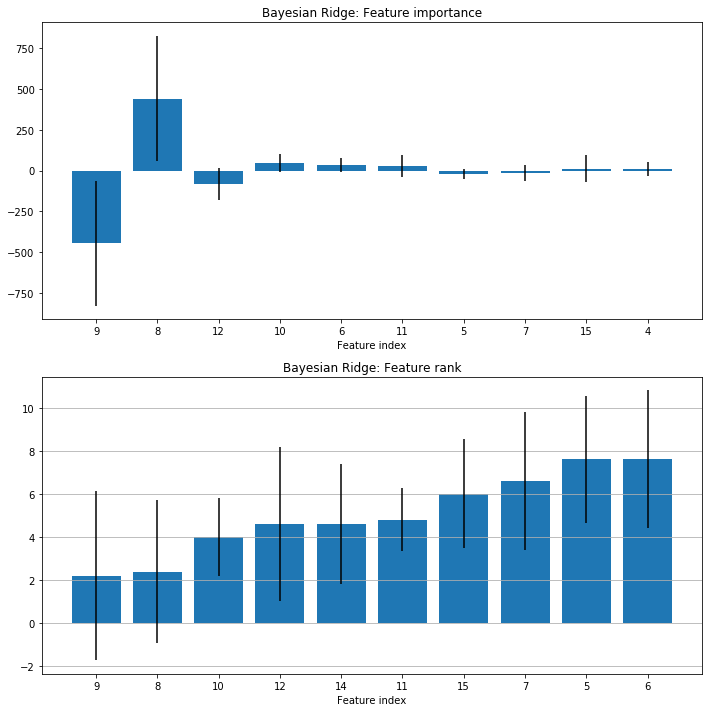

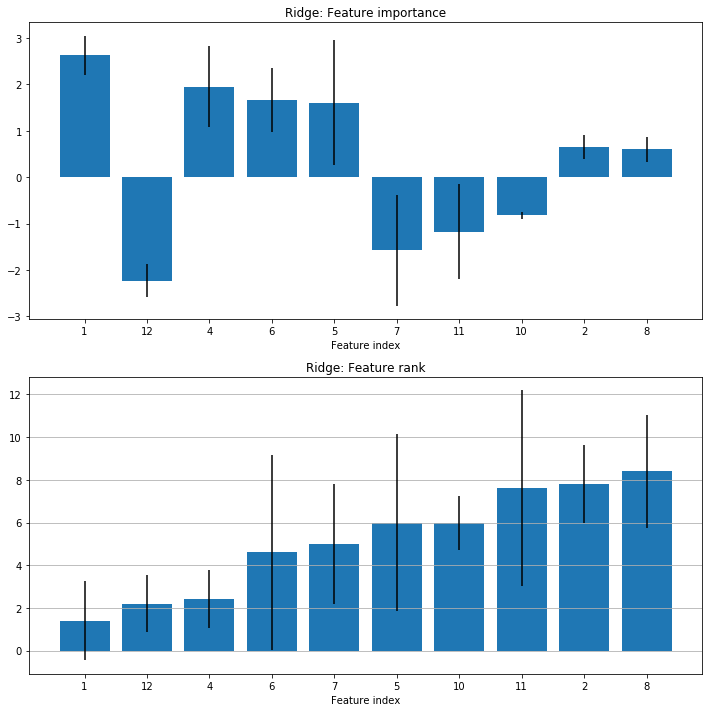

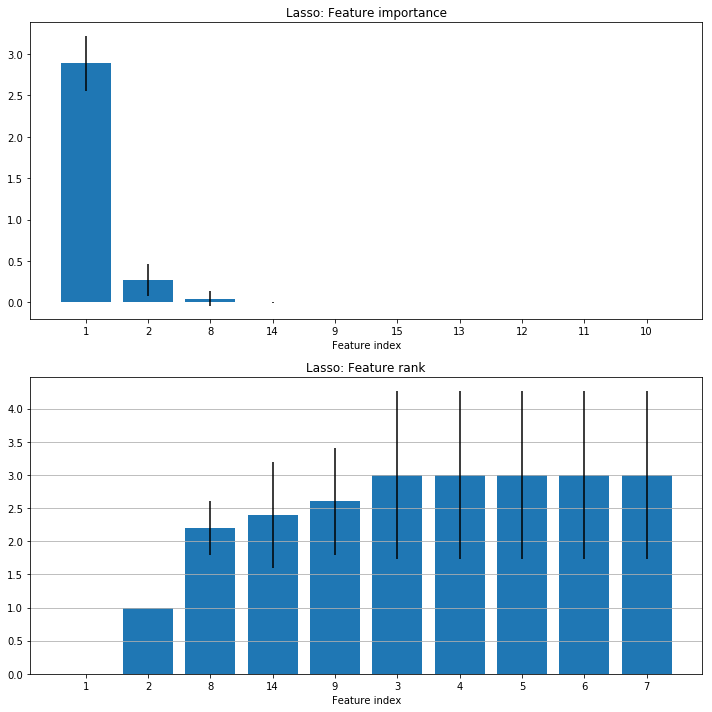

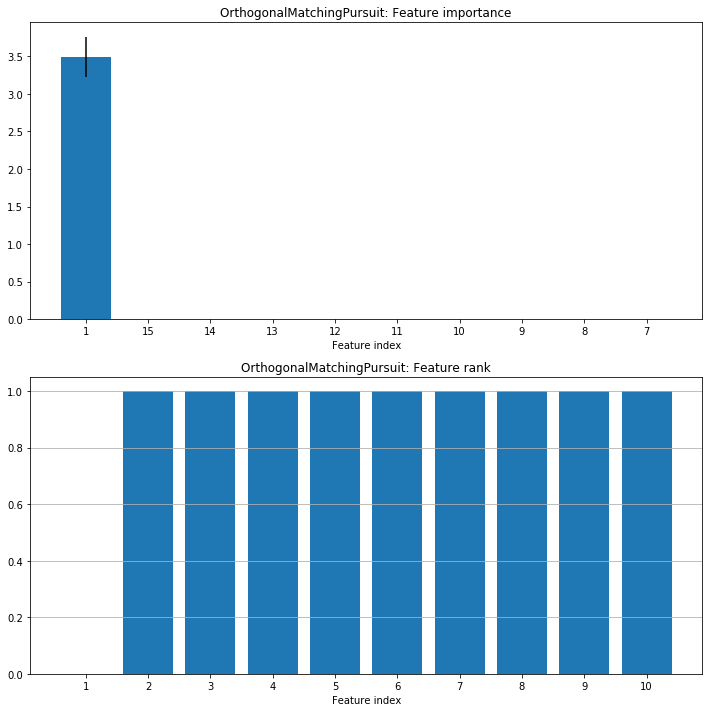

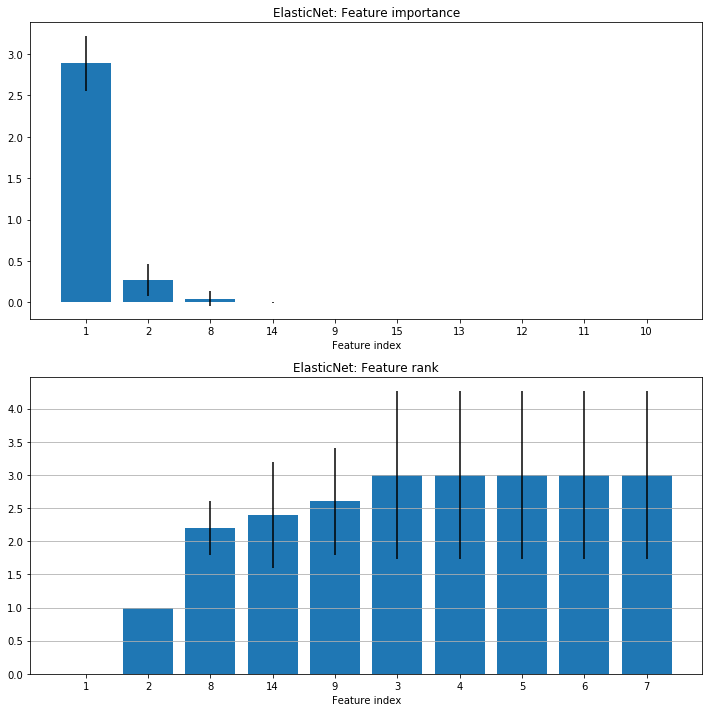

In [53]:
dataset ='mse_eHealthData'

# global  report
report = polyr(workingData, labels, n_folds=5, verbose=2, concurrency=1, feature_selection=False, scoring='mse', save=True,  project_name=dataset, exclude = ['PassiveAggressiveRegressor', 'GaussianProcessRegressor','Lars', 'LassoLars', 'Median'])

dir = 'polyr_' + dataset
with open(dir + '/report.pkl', 'wb') as f:
    p.dump(report, f, protocol=2)

report.scores.to_csv(dir+'/Scores_Detail.csv')
B = report.scores.astype('float').describe().transpose()[['mean', 'std', 'min', 'max']]
B.to_csv(dir+'/Scores_Report.csv')

with open(dir + '/report.pkl', 'rb') as p_f:
    report = p.load(p_f)

print(report.scores)
# Plot results
report.plot_scores(path=dir+'/temp')
report.plot_features(ntop=10, path=dir+'/temp')

# Turning into classification problem

In [54]:
# Logistic Regression Classifier
class LRTrainer():
    def __init__(self, tr_labels, test_labels, device):
        self.tr_labels = tr_labels
        self.test_labels = test_labels
        self.device = device

    def train(self, tr_eps, tst_eps, subjects_per_group, trial_no, run_dir):

        lrclf = LogisticRegression(fit_intercept=True, solver='lbfgs',
                                   penalty='l2')

        param_grid = {'C': [0.001, 0.1, 1]}

        scoring = {'Accuracy': make_scorer(accuracy_score)}
        # Instantiate the grid search model
        grid_search = GridSearchCV(estimator=lrclf, param_grid=param_grid,
                                   cv=3, n_jobs=1, scoring=make_scorer(accuracy_score), verbose=1)


        # Fit the grid search to the data
        grid_search.fit(tr_eps, self.tr_labels)
        pprint(grid_search.best_params_)

        best_grid = grid_search.best_estimator_
        y_pred = best_grid.predict(tst_eps)
        
        X = tst_eps
        y = self.test_labels
        
        accuracy = accuracy_score(y, y_pred)
        print(accuracy)
        precision = precision_score(y, y_pred, average='micro')
        recall = recall_score(y, y_pred, average='micro')
        confusion_mat = confusion_matrix(y, y_pred)
       
        return accuracy, precision, recall, confusion_mat


In [55]:
X = workingData
Y = labels
Y = np.squeeze(Y)
print(Y)
encoder = LabelEncoder()
encoder.fit(labels)
encoded_Y = encoder.transform(Y)

print(encoded_Y)

seed = 9
np.random.seed(seed)

(X_train, X_test, Y_train, Y_test) = train_test_split(X, encoded_Y, test_size=0.10, random_state=seed)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

[ 8.  8.  8. ... 15. 15. 15.]
[ 7  7  7 ... 14 14 14]
(24953, 15)
(24953,)
(2773, 15)
(2773,)


In [56]:
trainer = LRTrainer(Y_train, Y_test, "cpu")
accuracy, precision, recall, confusion_mat = trainer.train(X_train, X_test, 0, 1, "")

print("Grid Searched LR Accuracy:", accuracy)
print("Grid Searched LR Precision:", precision)
print("Grid Searched LR Recall:", recall)
print(confusion_mat)


Fitting 3 folds for each of 3 candidates, totalling 9 fits


/Users/mdmahfuzurrahman/anaconda3/envs/tensor/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   16.3s finished


{'C': 0.001}
0.6574107464839524
Grid Searched LR Accuracy: 0.6574107464839524
Grid Searched LR Precision: 0.6574107464839524
Grid Searched LR Recall: 0.6574107464839524
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    3]
 [   0    0    0    0    1    0    1    0    0    0    0    0    0   50]
 [   0    0    0    0    2    0    3    0    0    0    0    0    0    7]
 [   0    0    0    0   38    0    3    0    0    0    0    0    0   12]
 [   0    0    0    0   73    2   19    1    0    0    0    0    0   23]
 [   0    0    0    0   54   22   95   11    0    0    0    0    0   23]
 [   0    0    0    0    7   46  170   62    0    0    0    0    0   55]
 [   0    0    0    0    0    5   84   63    0    0    0    0    0   23]
 [   0    0    0    0    0    0   16   24    0    0    0    0    0   50]
 [   0    0    0    0    0    0    3    2    0    0    0    0    0   46]
 [   0    0    0    0    0    0    1    0    0    0    0    0    0   87]
 [   0    0    0    0    0  